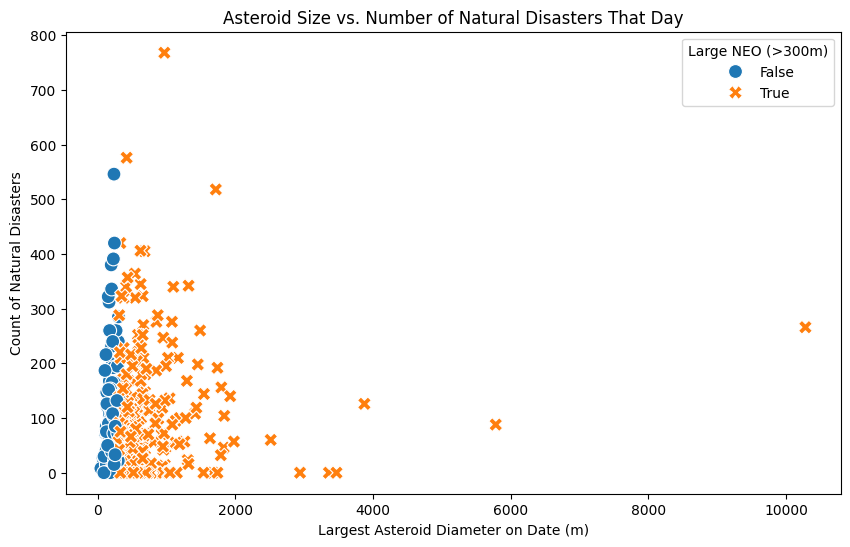

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


merged_df = pd.read_csv("merged_neo_disaster_data.csv")

merged_df['date'] = pd.to_datetime(merged_df['date'])

LARGE_DIAMETER_THRESHOLD = 300  

asteroid_df = merged_df.dropna(subset=["diameter_max_m"])

disaster_count = asteroid_df.groupby("date")['disaster_type'].count().reset_index()
disaster_count.rename(columns={"disaster_type": "disaster_count"}, inplace=True)

asteroid_by_date = asteroid_df.groupby("date")['diameter_max_m'].max().reset_index()
asteroid_by_date.rename(columns={"diameter_max_m": "max_diameter_m"}, inplace=True)

plot_df = pd.merge(asteroid_by_date, disaster_count, on="date", how="left")
plot_df["disaster_count"] = plot_df["disaster_count"].fillna(0)

plot_df["large_neo"] = plot_df["max_diameter_m"] > LARGE_DIAMETER_THRESHOLD

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=plot_df,
    x="max_diameter_m", 
    y="disaster_count",
    hue="large_neo", 
    style="large_neo",
    s=100
)

plt.title("Asteroid Size vs. Number of Natural Disasters That Day")
plt.xlabel("Largest Asteroid Diameter on Date (m)")
plt.ylabel("Count of Natural Disasters")
plt.legend(title="Large NEO (>300m)")
plt.show()

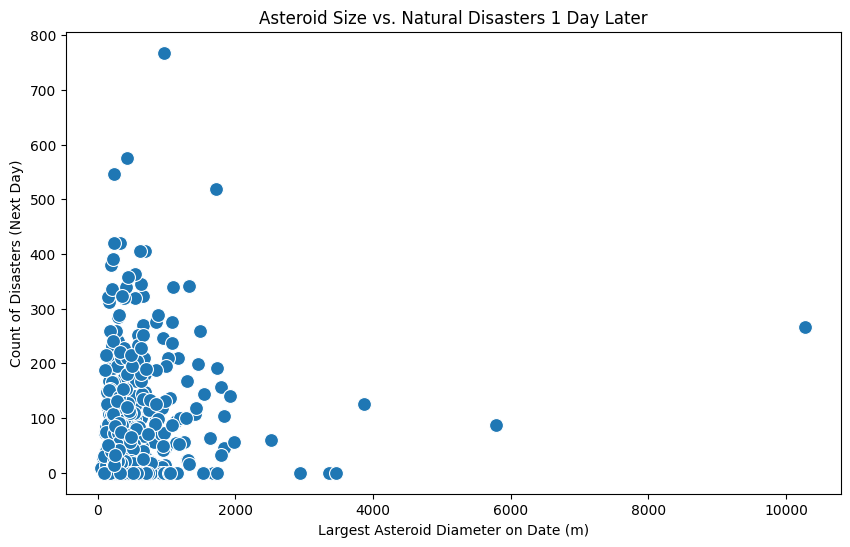

In [29]:
asteroid_df_shifted = plot_df.copy()
asteroid_df_shifted['date'] = asteroid_df_shifted['date'] - pd.Timedelta(days=1)

lagged_plot_df = pd.merge(
    asteroid_by_date, 
    disaster_count.rename(columns={"date": "date_plus_1"}),
    left_on="date",
    right_on="date_plus_1",
    how="left"
)

lagged_plot_df["disaster_count"] = lagged_plot_df["disaster_count"].fillna(0)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=lagged_plot_df,
    x="max_diameter_m", 
    y="disaster_count",
    s=100
)
plt.title("Asteroid Size vs. Natural Disasters 1 Day Later")
plt.xlabel("Largest Asteroid Diameter on Date (m)")
plt.ylabel("Count of Disasters (Next Day)")
plt.show()

In [30]:
plot_df[['max_diameter_m', 'disaster_count']].corr()

,max_diameter_m,disaster_count
max_diameter_m,1.000000,0.068723
disaster_count,0.068723,1.000000


In [31]:
hazardous_df = merged_df[merged_df['hazardous'] == True].copy()

In [32]:
hazardous_by_date = hazardous_df.groupby("date")['diameter_max_m'].max().reset_index()
hazardous_by_date.rename(columns={"diameter_max_m": "max_diameter_m"}, inplace=True)

disaster_count_haz = hazardous_df.groupby("date")['disaster_type'].count().reset_index()
disaster_count_haz.rename(columns={"disaster_type": "disaster_count"}, inplace=True)

haz_plot_df = pd.merge(hazardous_by_date, disaster_count_haz, on="date", how="outer").fillna(0)

In [33]:
correlation = haz_plot_df[['max_diameter_m', 'disaster_count']].corr()
correlation

,max_diameter_m,disaster_count
max_diameter_m,1.000000,0.020589
disaster_count,0.020589,1.000000


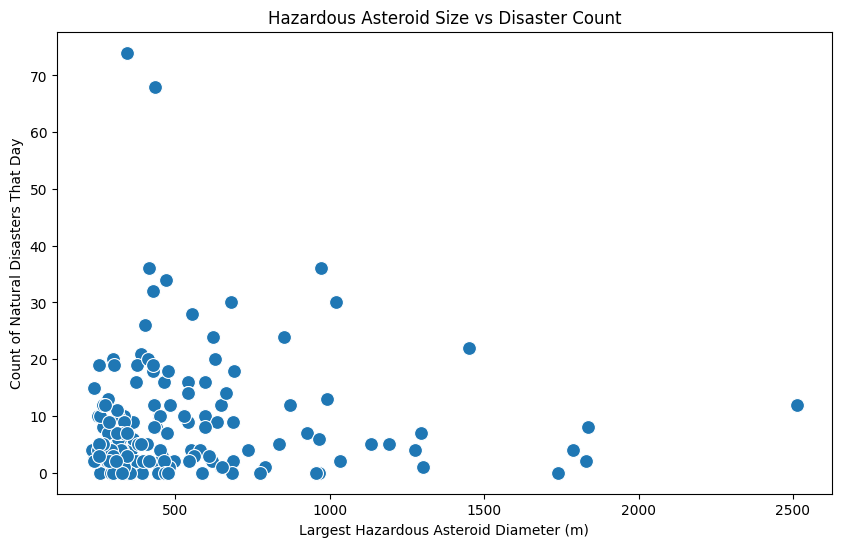

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=haz_plot_df,
    x="max_diameter_m",
    y="disaster_count",
    s=100
)
plt.title("Hazardous Asteroid Size vs Disaster Count")
plt.xlabel("Largest Hazardous Asteroid Diameter (m)")
plt.ylabel("Count of Natural Disasters That Day")
plt.show()

In [35]:
top5 = haz_plot_df.nlargest(5, 'max_diameter_m')
top5

,date,max_diameter_m,disaster_count
113,2025-08-02,2512.117673,12
13,2024-12-19,1836.707413,8
4,2024-12-02,1828.268509,2
73,2025-05-15,1786.652037,4
128,2025-09-15,1737.960809,0


When examining the top 5 largest hazardous asteroids detected in the past year, disaster counts on their corresponding dates remained within normal daily ranges (0–20 incidents). None of these dates showed statistically abnormal activity. This further supports the conclusion that asteroid size — even among potentially hazardous objects — does not influence natural disaster occurrence in the near term.

In [36]:
hazardous_df['disaster_type'].value_counts()

disaster_type
Wildfires           1086
Sea and Lake Ice     276
Severe Storms         19
Volcanoes              7
Name: count, dtype: int64

In [37]:
haz_by_type = hazardous_df.groupby(["date", "disaster_type"])['diameter_max_m'].max().reset_index()

haz_by_type['event_count'] = hazardous_df.groupby(["date", "disaster_type"])['disaster_type'].transform('count')

haz_by_type.head()

,date,disaster_type,diameter_max_m,event_count
0,2024-11-23,Wildfires,354.846053,NaN
1,2024-11-25,Wildfires,1300.289270,NaN
2,2024-11-26,Wildfires,326.617897,NaN
3,2024-11-30,Wildfires,363.111479,NaN
4,2024-12-02,Wildfires,1828.268509,NaN


In [38]:
results = {}

for dtype in haz_by_type['disaster_type'].unique():
    subset = haz_by_type[haz_by_type['disaster_type'] == dtype]
    if len(subset) > 1:  # need at least 2 data points
        corr = subset[['diameter_max_m', 'event_count']].corr().iloc[0,1]
        results[dtype] = corr

results

{'Wildfires': np.float64(nan),
 'Volcanoes': np.float64(nan),
 'Sea and Lake Ice': np.float64(nan),
 'Severe Storms': np.float64(nan)}

In [39]:
disaster_type_counts = hazardous_df['disaster_type'].value_counts()
disaster_type_counts

disaster_type
Wildfires           1086
Sea and Lake Ice     276
Severe Storms         19
Volcanoes              7
Name: count, dtype: int64

In [40]:
hazardous_day_counts = hazardous_df['disaster_type'].value_counts()
hazardous_day_counts

disaster_type
Wildfires           1086
Sea and Lake Ice     276
Severe Storms         19
Volcanoes              7
Name: count, dtype: int64

In [41]:
hazardous_dates = hazardous_df['date'].unique()

disasters_on_hazardous_dates = merged_df[merged_df['date'].isin(hazardous_dates)]

final_disaster_counts = disasters_on_hazardous_dates['disaster_type'].value_counts()
final_disaster_counts

disaster_type
Wildfires           13102
Sea and Lake Ice     2764
Severe Storms         213
Volcanoes              80
Name: count, dtype: int64

In [42]:
unique_disasters = disasters_on_hazardous_dates[['date', 'disaster_type']].drop_duplicates()

unique_disaster_counts = unique_disasters['disaster_type'].value_counts()
unique_disaster_counts

disaster_type
Wildfires           132
Sea and Lake Ice     17
Volcanoes             6
Severe Storms         4
Name: count, dtype: int64

In [43]:
total_disaster_counts = merged_df['disaster_type'].value_counts()
percent_comparison = (unique_disaster_counts / total_disaster_counts * 100).round(2)
percent_comparison

disaster_type
Wildfires           0.46
Sea and Lake Ice    0.23
Volcanoes           2.27
Severe Storms       1.58
Name: count, dtype: float64

In [44]:
corr_by_type = {}

for dtype in unique_disasters['disaster_type'].unique():
    subset = unique_disasters[unique_disasters['disaster_type'] == dtype].copy()
    subset = subset.merge(hazardous_by_date, on='date', how='left')
    
    if subset['max_diameter_m'].nunique() > 1:
        corr = subset[['max_diameter_m', 'date']].corr().iloc[0,1]
        corr_by_type[dtype] = corr
    else:
        corr_by_type[dtype] = None

corr_by_type

{'Wildfires': np.float64(-0.10795767003117004),
 'Volcanoes': np.float64(0.4416953745643868),
 'Sea and Lake Ice': np.float64(0.18836171039180175),
 nan: None,
 'Severe Storms': np.float64(-0.7457043172062549)}

Looks like volcanos COULD be meaningful, but we need to increase our sample size

### Miss distance vs disaster count

In [49]:
df = merged_df[['disaster_type', 'miss_distance_km', 'hazardous']].dropna()

df['hazardous'] = df['hazardous'].astype(int)

correlations = {}

for dtype, group in df.groupby('disaster_type'):
    if group['miss_distance_km'].nunique() > 1:
        corr = group['hazardous'].corr(group['miss_distance_km'])
        correlations[dtype] = corr
    else:
        correlations[dtype] = None
correlations

{'Sea and Lake Ice': np.float64(0.0519461837069563),
 'Severe Storms': np.float64(-0.019254528540435956),
 'Volcanoes': np.float64(0.021274738883722045),
 'Wildfires': np.float64(0.04423439499500035)}

no correlation

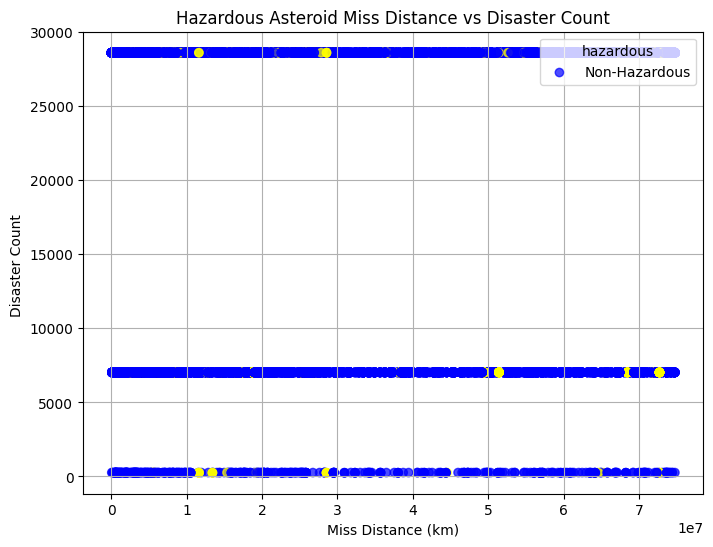

In [59]:
df = merged_df[['hazardous', 'miss_distance_km', 'disaster_type']].dropna()
df['hazardous'] = df['hazardous'].astype(int)
disaster_counts = df['disaster_type'].value_counts().rename('disaster_count')
df = df.merge(disaster_counts, left_on='disaster_type', right_index=True)

colors = df['hazardous'].map({1: 'yellow', 0: 'blue'})
plt.figure(figsize=(8,6))
plt.scatter(
    df['miss_distance_km'],
    df['disaster_count'],
    c=colors,
    alpha=0.7
)
plt.xlabel("Miss Distance (km)")
plt.ylabel("Disaster Count ")
plt.title("Hazardous Asteroid Miss Distance vs Disaster Count")
plt.legend(title="hazardous", labels=["Non-Hazardous", "Hazardous"], loc="upper right")


plt.grid(True)
plt.show()